In [19]:
import numpy as np
import pychrono as chrono

from rostok.block_builder_api.block_blueprints import (PrimitiveBodyBlueprint,
                                                       RevolveJointBlueprint,
                                                       TransformBlueprint)
from rostok.block_builder_api.block_parameters import JointInputType
from rostok.block_builder_api.easy_body_shapes import Box, Cylinder, Ellipsoid
from rostok.block_builder_chrono.blocks_utils import FrameTransform
from rostok.graph_grammar import rule_vocabulary
from rostok.graph_grammar.node import ROOT
from rostok.graph_grammar.node_vocabulary import NodeVocabulary
from rostok.utils.dataset_materials.material_dataclass_manipulating import (
    DefaultChronoMaterialNSC, DefaultChronoMaterialSMC)
from rostok.graph_grammar.node import GraphGrammar
from rostok.graph_grammar.graph_utils import plot_graph

In [20]:
def get_density_box(mass: float, box: Box):
    volume = box.height_z * box.length_y * box.width_x
    return mass / volume

def rotation_x(alpha):
    quat_X_ang_alpha = chrono.Q_from_AngX(np.deg2rad(alpha))
    return [quat_X_ang_alpha.e0, quat_X_ang_alpha.e1, quat_X_ang_alpha.e2, quat_X_ang_alpha.e3]

def rotation_y(alpha):
    quat_Y_ang_alpha = chrono.Q_from_AngY(np.deg2rad(alpha))
    return [quat_Y_ang_alpha.e0, quat_Y_ang_alpha.e1, quat_Y_ang_alpha.e2, quat_Y_ang_alpha.e3]

def rotation_z(alpha):
    quat_Z_ang_alpha = chrono.Q_from_AngZ(np.deg2rad(alpha))
    return [quat_Z_ang_alpha.e0, quat_Z_ang_alpha.e1, quat_Z_ang_alpha.e2, quat_Z_ang_alpha.e3]

def_mat = DefaultChronoMaterialNSC()

In [21]:
node_vocab = NodeVocabulary()
node_vocab.add_node(ROOT)
node_vocab.create_node(label="MB")
node_vocab.create_node(label="L")
node_vocab.create_node(label="W")
node_vocab.create_node(label="J")
node_vocab.create_node(label="R")
node_vocab.create_node(label="G")

node_vocab.create_node(label="XT")
node_vocab.create_node(label="ZT")


In [22]:
from copy import deepcopy
# blueprint for the palm
main_body = []

for i in range(10):
    main_body.append(PrimitiveBodyBlueprint(
        Box(0.5, 0.1, 0.3), material=def_mat, color=[255, 0, 0], density=100+i*100,is_collide=True))
    
wheel_def_mat = deepcopy(def_mat)
wheel_def_mat.Friction = 0.5
wheel_def_mat.RollingFriction=0.0001
wheel_def_mat.SpinningFriction=0.0001
wheel_body_cyl = PrimitiveBodyBlueprint(
    Cylinder(0.03, 0.02), material=wheel_def_mat, color=[120, 120, 120], density=1000)

wheel_body_cyl_wide = PrimitiveBodyBlueprint(
    Cylinder(0.03, 0.06), material=wheel_def_mat, color=[120, 120, 120], density=3000)

wheel_body_ell = PrimitiveBodyBlueprint(
    Ellipsoid(0.06,0.06, 0.04), material=def_mat, color=[120, 120, 120], density=1000)

# blueprint for the base
base = PrimitiveBodyBlueprint(Box(0.02, 0.03, 0.02),
                                material=def_mat,
                                color=[120, 120, 0],
                                density=1000)

# sets effective density for the links, the real links are considered to be extendable.

length_link = np.linspace(0.05, 0.1, 5)
# create link blueprints using mass and length parameters
link = list(map(lambda x: PrimitiveBodyBlueprint(Box(0.02, x, 0.02),
                                            material=def_mat,
                                            color=[0, 120, 255],
                                            density=1000), length_link))

dummy_link = PrimitiveBodyBlueprint(
    Box(0.01, 0.001, 0.01), material=def_mat, density=1000000)

In [23]:
0.3**2*3.14*0.2*500/(0.01**3*0.1)


282600000.0

In [24]:
for i, bp in enumerate(main_body):
    node_vocab.create_node(label=f"MB{i}", is_terminal=True, block_blueprint=bp)

for i, bp in enumerate(link):
    node_vocab.create_node(label=f"L{i}", is_terminal=True, block_blueprint=bp)

node_vocab.create_node(label="B", is_terminal=True,block_blueprint=base)
node_vocab.create_node(label="WC", is_terminal=True,block_blueprint=wheel_body_cyl)
node_vocab.create_node(label="WC2", is_terminal=True,block_blueprint=wheel_body_cyl_wide)
node_vocab.create_node(label="WE", is_terminal=True,block_blueprint=wheel_body_ell)

node_vocab.create_node(label="DB", is_terminal=True,
                        block_blueprint=dummy_link)

In [25]:
x_translation_values = np.linspace(0.0,0.25,5)
X_TRANSLATIONS_POSITIVE = list(
    map(lambda x: FrameTransform([x, 0, 0], [1, 0, 0, 0]), x_translation_values))
X_TRANSLATIONS_NEGATIVE=list(
    map(lambda x: FrameTransform([-x, 0, 0], [1, 0, 0, 0]), x_translation_values))
    # create transform blueprints from the values
x_translation_positive = list(
    map(lambda x: TransformBlueprint(x), X_TRANSLATIONS_POSITIVE))
x_translation_negative = list(
    map(lambda x: TransformBlueprint(x), X_TRANSLATIONS_NEGATIVE))

z_translation_values = np.linspace(0.0,0.15,5)
Z_TRANSLATIONS_POSITIVE = list(
    map(lambda x: FrameTransform([0, 0, x], [1, 0, 0, 0]), z_translation_values))
Z_TRANSLATIONS_NEGATIVE = list(
    map(lambda x: FrameTransform([0, 0, -x], [1, 0, 0, 0]), z_translation_values))

z_translation_positive = list(
    map(lambda x: TransformBlueprint(x), Z_TRANSLATIONS_POSITIVE))
z_translation_negative = list(
    map(lambda x: TransformBlueprint(x), Z_TRANSLATIONS_NEGATIVE))

In [26]:
for i, bp in enumerate(x_translation_positive):
    node_vocab.create_node(label=f"XTP{i}", is_terminal=True, block_blueprint=bp)

for i, bp in enumerate(x_translation_negative):
    node_vocab.create_node(label=f"XTN{i}", is_terminal=True, block_blueprint=bp)

for i, bp in enumerate(z_translation_positive):
    node_vocab.create_node(label=f"ZTP{i}", is_terminal=True, block_blueprint=bp)

for i, bp in enumerate(z_translation_negative):
    node_vocab.create_node(label=f"ZTN{i}", is_terminal=True, block_blueprint=bp)

In [27]:
TURN_X = FrameTransform([0, 0, 0], rotation_x(90))
turn_x_bp = TransformBlueprint(TURN_X)

TURN_Y = FrameTransform([0, 0, 0], rotation_y(90))
turn_y_bp = TransformBlueprint(TURN_Y)

TURN_Z = FrameTransform([0, 0, 0], rotation_z(90))
turn_z_bp = TransformBlueprint(TURN_Z)

In [28]:
node_vocab.create_node(label='XR',is_terminal=True, block_blueprint=turn_x_bp)
node_vocab.create_node(label='YR',is_terminal=True, block_blueprint=turn_y_bp)
node_vocab.create_node(label='ZR',is_terminal=True, block_blueprint=turn_z_bp)

In [29]:
stiffness = np.linspace(0.1,5,50)

no_control_joint = list(
    map(lambda x: RevolveJointBlueprint(JointInputType.UNCONTROL,
                                            stiffness=x,
                                            damping=0.005,
                                            equilibrium_position=0), stiffness))
motor_bp = RevolveJointBlueprint(JointInputType.TORQUE,  stiffness=0, damping=0.002)
neutral_bp = RevolveJointBlueprint(JointInputType.UNCONTROL,  stiffness=0, damping=0.002)

In [30]:
node_vocab.create_node(label="RM", is_terminal=True, block_blueprint=motor_bp)
node_vocab.create_node(label="LM", is_terminal=True, block_blueprint=motor_bp)
node_vocab.create_node(label="NM", is_terminal=True, block_blueprint=neutral_bp)

for i, bp in enumerate(no_control_joint):
    node_vocab.create_node(label=f"J{i}", is_terminal=True, block_blueprint=bp)

In [31]:
rule_vocab = rule_vocabulary.RuleVocabulary(node_vocab)
# structural rules
rule_vocab.create_rule("Init", ["ROOT"], ["MB"], 0, 0,[])
rule_vocab.create_rule("Add_Leg_Base",["MB"],["MB","XT","ZT","B","G"],0,0,[(0,1),(1,2),(2,3),(3,4)])

rule_vocab.create_rule("Add_Dummy", ["G"], ["J","DB", "G"],0,0,[(0, 1), (1, 2)])
rule_vocab.create_rule("Extension",["G"],["J","L", "G"], 0,2,[(0, 1), (1, 2)])
rule_vocab.create_rule("R_Wheel",["G"], ["RM","W"],0,0,[(0,1)])
rule_vocab.create_rule("L_Wheel",["G"], ["LM","W"],0,0,[(0,1)])
rule_vocab.create_rule("Wheel",["G"], ["NM","W"],0,0,[(0,1)])
rule_vocab.create_rule("Rotation",["G"],["R","G"],0,0,[(0,1)])
rule_vocab.create_rule("Remove",["G"],[],0,0,[])

In [32]:
for i in range(len(main_body)):
    rule_vocab.create_rule(f'Terminal_Main_Body{i}',["MB"],[f"MB{i}"],0,0,[])

for i in range(len(link)):
    rule_vocab.create_rule(f'Terminal_Link{i}',["L"],[f"L{i}"],0,0,[])

for i in range(len(no_control_joint)):
    rule_vocab.create_rule(f'Terminal_Joint{i}',["J"],[f"J{i}"],0,0,[])

for i in range(len(x_translation_positive)):
    rule_vocab.create_rule(f'Positive_Translation_X{i}',["XT"],[f"XTP{i}"],0,0,[])
for i in range(len(x_translation_negative)):
    rule_vocab.create_rule(f'Negative_Translation_X{i}',["XT"],[f"XTN{i}"],0,0,[])
for i in range(len(z_translation_positive)):
    rule_vocab.create_rule(f'Positive_Translation_Z{i}',["ZT"],[f"ZTP{i}"],0,0,[])
for i in range(len(z_translation_negative)):
    rule_vocab.create_rule(f'Negative_Translation_Z{i}',["ZT"],[f"ZTN{i}"],0,0,[])

rule_vocab.create_rule(f'Rotation_X',["R"],["XR"],0,0,[])
rule_vocab.create_rule(f'Rotation_Y',["R"],["YR"],0,0,[])
rule_vocab.create_rule(f'Rotation_Z',["R"],["ZR"],0,0,[])

rule_vocab.create_rule("Cyl_Wheel",["W"],["WC"],0,0,[])
rule_vocab.create_rule("Cyl_Wheel2",["W"],["WC2"],0,0,[])
rule_vocab.create_rule("Ell_Wheel",["W"],["WE"],0,0,[])

In [33]:
def get_initial_mech(rule_vocabul):
    graph = GraphGrammar()
    rules = ["Init",
        "Add_Leg_Base","Positive_Translation_X4","Positive_Translation_Z3", "Extension","Extension","Remove",
        "Terminal_Link3","Terminal_Link3",'Terminal_Joint2','Terminal_Joint2',

        "Add_Leg_Base","Positive_Translation_X4","Negative_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",
        "Terminal_Link3","Terminal_Link3",'Terminal_Joint2','Terminal_Joint2', "Remove",

        "Add_Leg_Base","Negative_Translation_X4","Negative_Translation_Z0", "Extension","Extension",
        "Terminal_Link3","Terminal_Link3",'Terminal_Joint2','Terminal_Joint2', "Wheel", "Ell_Wheel",

        'Terminal_Main_Body1'

    ]

    for rule in rules:
        graph.apply_rule(rule_vocabul.get_rule(rule))

    starting_angles = [ [15,-30,0,0], [-15,30,0,0], [0,10,0,0]]
    return graph, starting_angles

def get_zero_rotation_four_legs(rule_vocabul):
    i=3
    graph = GraphGrammar()
    rules = ["Init",
        "Add_Leg_Base","Positive_Translation_X2","Positive_Translation_Z2", "Extension","Extension", f'Terminal_Joint{i}',f'Terminal_Joint{i}',
        "R_Wheel", "Cyl_Wheel", "Terminal_Link2","Terminal_Link2",

        "Add_Leg_Base","Positive_Translation_X2","Negative_Translation_Z2", "Extension","Extension", f'Terminal_Joint{i}',f'Terminal_Joint{i}',
        "R_Wheel", "Cyl_Wheel", "Terminal_Link2","Terminal_Link2",

        "Add_Leg_Base","Negative_Translation_X2","Positive_Translation_Z2", "Extension","Extension", f'Terminal_Joint{i}',f'Terminal_Joint{i}',
        "R_Wheel", "Cyl_Wheel", "Terminal_Link2","Terminal_Link2",

        "Add_Leg_Base","Negative_Translation_X2","Negative_Translation_Z2", "Extension","Extension", f'Terminal_Joint{i}',f'Terminal_Joint{i}',
        "R_Wheel", "Cyl_Wheel", "Terminal_Link2","Terminal_Link2",

        'Terminal_Main_Body3'
    
    ]

    for rule in rules:
        graph.apply_rule(rule_vocabul.get_rule(rule))

    starting_angles = [ [15,-30,0,0], [15,-30,0,0], [15,-30,0,0], [15,-30,0,0]]
    return graph, starting_angles

def get_rotated_four_legs(rule_vocabul):
    l=1
    j= 5
    graph = GraphGrammar()
    rules = ["Init",
    "Add_Leg_Base","Positive_Translation_X2","Positive_Translation_Z2","Rotation",
    'Rotation_Y', "Extension","Extension",f'Terminal_Joint{j}',f'Terminal_Joint{j}', "Rotation","R_Wheel", "Cyl_Wheel",
    f"Terminal_Link{l}",f"Terminal_Link{l}",'Rotation_Y',

    "Add_Leg_Base","Positive_Translation_X2","Negative_Translation_Z2","Rotation",
    'Rotation_Y', "Extension","Extension",f'Terminal_Joint{j}',f'Terminal_Joint{j}',"Rotation","L_Wheel", "Cyl_Wheel",
    f"Terminal_Link{l}",f"Terminal_Link{l}", 'Rotation_Y',

    "Add_Leg_Base","Negative_Translation_X2","Positive_Translation_Z2","Rotation",
    'Rotation_Y', "Extension","Extension",f'Terminal_Joint{j}', f'Terminal_Joint{j}',"Rotation","R_Wheel", "Cyl_Wheel",
    f"Terminal_Link{l}",f"Terminal_Link{l}", 'Rotation_Y',

    "Add_Leg_Base","Negative_Translation_X2","Negative_Translation_Z2","Rotation",
    'Rotation_Y', "Extension","Extension",f'Terminal_Joint{j}',f'Terminal_Joint{j}',  "Rotation","L_Wheel", "Cyl_Wheel",
    f"Terminal_Link{l}",f"Terminal_Link{l}",'Rotation_Y',

    'Terminal_Main_Body2'
    
    ]

    for rule in rules:
        graph.apply_rule(rule_vocabul.get_rule(rule))

    starting_angles = [[-30,30,0,0], [30,-30,0,0], [-30,30,0,0], [30,-30,0,0]]
    return graph, starting_angles

def get_rotated_four_legs(rule_vocabul):
    l=1
    j= 5
    graph = GraphGrammar()
    rules = ["Init",
    "Add_Leg_Base","Positive_Translation_X2","Positive_Translation_Z2","Rotation",
    'Rotation_Y', "Extension","Extension",f'Terminal_Joint{j}',f'Terminal_Joint{j}', "Rotation","R_Wheel", "Cyl_Wheel",
    f"Terminal_Link{l}",f"Terminal_Link{l}",'Rotation_Y',

    "Add_Leg_Base","Positive_Translation_X2","Negative_Translation_Z2","Rotation",
    'Rotation_Y', "Extension","Extension",f'Terminal_Joint{j}',f'Terminal_Joint{j}',"Rotation","L_Wheel", "Cyl_Wheel",
    f"Terminal_Link{l}",f"Terminal_Link{l}", 'Rotation_Y',

    "Add_Leg_Base","Negative_Translation_X2","Positive_Translation_Z2","Rotation",
    'Rotation_Y', "Extension","Extension",f'Terminal_Joint{j}', f'Terminal_Joint{j}',"Rotation","R_Wheel", "Cyl_Wheel",
    f"Terminal_Link{l}",f"Terminal_Link{l}", 'Rotation_Y',

    "Add_Leg_Base","Negative_Translation_X2","Negative_Translation_Z2","Rotation",
    'Rotation_Y', "Extension","Extension",f'Terminal_Joint{j}',f'Terminal_Joint{j}',  "Rotation","L_Wheel", "Cyl_Wheel",
    f"Terminal_Link{l}",f"Terminal_Link{l}",'Rotation_Y',

    'Terminal_Main_Body2'
    
    ]

    for rule in rules:
        graph.apply_rule(rule_vocabul.get_rule(rule))

    starting_angles = [[-30,30,0,0], [30,-30,0,0], [-30,30,0,0], [30,-30,0,0]]
    return graph, starting_angles

def get_rotated_four_legs_with_db(rule_vocabul, stiffness_idx):
    i=stiffness_idx
    graph = GraphGrammar()
    rules = ["Init",
        "Add_Leg_Base","Positive_Translation_X4","Positive_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}',f'Terminal_Joint{i}', "Add_Dummy","Rotation","R_Wheel", "Cyl_Wheel2",
        "Terminal_Link3","Terminal_Link3", 'Terminal_Joint10','Rotation_Y',

        "Add_Leg_Base","Positive_Translation_X4","Negative_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}',f'Terminal_Joint{i}',"Add_Dummy","Rotation","L_Wheel", "Cyl_Wheel2",
        "Terminal_Link3","Terminal_Link3", 'Terminal_Joint10','Rotation_Y',

        "Add_Leg_Base","Negative_Translation_X4","Positive_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}', f'Terminal_Joint{i}',"Add_Dummy","Rotation","R_Wheel", "Cyl_Wheel2",
        "Terminal_Link3","Terminal_Link3", 'Terminal_Joint10','Rotation_Y',

        "Add_Leg_Base","Negative_Translation_X4","Negative_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}',f'Terminal_Joint{i}', "Add_Dummy", "Rotation","L_Wheel", "Cyl_Wheel2",
        "Terminal_Link3","Terminal_Link3",'Terminal_Joint10','Rotation_Y',

        'Terminal_Main_Body4'
        
    ]

    for rule in rules:
        graph.apply_rule(rule_vocab.get_rule(rule))
    starting_angles = [[-30,30,0,0], [30,-30,0,0], [-30,30,0,0], [30,-30,0,0]]

    return graph, starting_angles


def get_rotated_six_legs_with_db(rule_vocabul, stiffness_idx):
    i=stiffness_idx
    k=10
    graph = GraphGrammar()
    rules = ["Init",
        "Add_Leg_Base","Positive_Translation_X4","Positive_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}',f'Terminal_Joint{i}', "Add_Dummy","Rotation","R_Wheel", "Cyl_Wheel2",
        "Terminal_Link3","Terminal_Link3", f'Terminal_Joint{k}','Rotation_Y',

        "Add_Leg_Base","Positive_Translation_X4","Negative_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}',f'Terminal_Joint{i}',"Add_Dummy","Rotation","L_Wheel", "Cyl_Wheel2",
        "Terminal_Link3","Terminal_Link3", f'Terminal_Joint{k}','Rotation_Y',

        "Add_Leg_Base","Negative_Translation_X4","Positive_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}', f'Terminal_Joint{i}',"Add_Dummy","Rotation","R_Wheel", "Cyl_Wheel2",
        "Terminal_Link3","Terminal_Link3", f'Terminal_Joint{k}','Rotation_Y',

        "Add_Leg_Base","Negative_Translation_X4","Negative_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}',f'Terminal_Joint{i}', "Add_Dummy", "Rotation","L_Wheel", "Cyl_Wheel2",
        "Terminal_Link3","Terminal_Link3",f'Terminal_Joint{k}','Rotation_Y',

        "Add_Leg_Base","Negative_Translation_X0","Positive_Translation_Z4","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}', f'Terminal_Joint{i}',"Add_Dummy","Rotation","R_Wheel", "Cyl_Wheel2",
        "Terminal_Link3","Terminal_Link3", f'Terminal_Joint{k}','Rotation_Y',

        "Add_Leg_Base","Negative_Translation_X0","Negative_Translation_Z4","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}',f'Terminal_Joint{i}', "Add_Dummy", "Rotation","L_Wheel", "Cyl_Wheel2",
        "Terminal_Link3","Terminal_Link3",f'Terminal_Joint{k}','Rotation_Y',

        'Terminal_Main_Body2'
        
    ]

    for rule in rules:
        graph.apply_rule(rule_vocab.get_rule(rule))
    starting_angles = [[-30,30,0,0], [30,-30,0,0], [-30,30,0,0], [30,-30,0,0], [-30,30,0,0], [30,-30,0,0]]

    return graph, starting_angles


def get_rotated_six_legs_with_db_ell(rule_vocabul, stiffness_idx):
    i=stiffness_idx
    graph = GraphGrammar()
    rules = ["Init",
        "Add_Leg_Base","Positive_Translation_X4","Positive_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}',f'Terminal_Joint{i}', "Add_Dummy","Rotation","R_Wheel", "Ell_Wheel",
        "Terminal_Link3","Terminal_Link3", 'Terminal_Joint40','Rotation_Y',

        "Add_Leg_Base","Positive_Translation_X4","Negative_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}',f'Terminal_Joint{i}',"Add_Dummy","Rotation","L_Wheel", "Ell_Wheel",
        "Terminal_Link3","Terminal_Link3", 'Terminal_Joint40','Rotation_Y',

        "Add_Leg_Base","Negative_Translation_X4","Positive_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}', f'Terminal_Joint{i}',"Add_Dummy","Rotation","R_Wheel", "Ell_Wheel",
        "Terminal_Link3","Terminal_Link3", 'Terminal_Joint40','Rotation_Y',

        "Add_Leg_Base","Negative_Translation_X4","Negative_Translation_Z3","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}',f'Terminal_Joint{i}', "Add_Dummy", "Rotation","L_Wheel", "Ell_Wheel",
        "Terminal_Link3","Terminal_Link3",'Terminal_Joint40','Rotation_Y',

        "Add_Leg_Base","Negative_Translation_X0","Positive_Translation_Z4","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}', f'Terminal_Joint{i}',"Add_Dummy","Rotation","R_Wheel", "Ell_Wheel",
        "Terminal_Link3","Terminal_Link3", 'Terminal_Joint40','Rotation_Y',

        "Add_Leg_Base","Negative_Translation_X0","Negative_Translation_Z4","Rotation",
        'Rotation_Y', "Extension","Extension",f'Terminal_Joint{i}',f'Terminal_Joint{i}', "Add_Dummy", "Rotation","L_Wheel", "Ell_Wheel",
        "Terminal_Link3","Terminal_Link3",'Terminal_Joint40','Rotation_Y',

        'Terminal_Main_Body8'
        
    ]

    for rule in rules:
        graph.apply_rule(rule_vocab.get_rule(rule))
    starting_angles = [[-30,30,0,0], [30,-30,0,0], [-30,30,0,0], [30,-30,0,0], [-30,30,0,0], [30,-30,0,0]]

    return graph, starting_angles


In [38]:
from rostok.simulation_chrono.simulation_scenario import SuspensionCarScenario
from rostok.criterion.simulation_flags import EventBodyTooLowBuilder, EventContactInInitialPositionBuilder
from rostok.control_chrono.controller import SimpleKeyBoardController

parameters = {}
parameters["forward"] = 1
parameters["reverse"]= 1
parameters["forward_rotate"] = 0.5
parameters["reverse_rotate"] = 0.3
control =  {"initial_value": [0.0]*6}

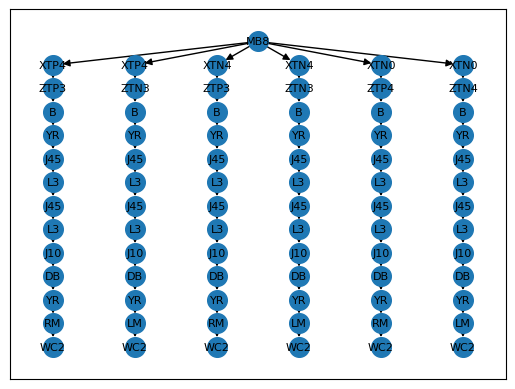

KeyboardInterrupt: 

In [43]:
scenario = SuspensionCarScenario(0.0001, 10,initial_vertical_pos=0.3,is_fixed=True)
graph,startings = get_initial_mech(rule_vocab)
graph,startings = get_zero_rotation_four_legs(rule_vocab)
graph,startings = get_rotated_four_legs(rule_vocab)
graph,startings = get_rotated_four_legs_with_db(rule_vocab, 15)
graph,startings = get_rotated_six_legs_with_db(rule_vocab, 45)
plot_graph(graph)
#scenario.add_event_builder(event_builder=EventBodyTooLowBuilder(0.15))
#scenario.add_event_builder(event_builder=EventContactInInitialPositionBuilder())
result = scenario.run_simulation(graph, control, starting_positions=startings, vis = True, delay=True)

In [36]:
# comment this cell if dont need to calculate the height
height = 0
graph,startings = get_rotated_four_legs_with_db(rule_vocab, 3)
for i in np.linspace(0.1,1,100):
    scenario = SuspensionCarScenario(0.0001, 0.01,initial_vertical_pos=i)
    scenario.add_event_builder(event_builder=EventBodyTooLowBuilder(0.15))
    scenario.add_event_builder(event_builder=EventContactInInitialPositionBuilder())
    result = scenario.run_simulation(graph, control, starting_positions=startings, vis = False, delay=False)
    if len(list(result.robot_final_ds.get_data("COG").items())[0][1]) > 10:
        height = i
        break

print(height)


0.28181818181818186


In [39]:
# comment this cell if dont need to calculate stiffness
n=20
stiffness = np.zeros(n)
for i in range(n):
    if i%10 == 0:    
        print(i)
    
    #graph,startings = get_rotated_four_legs_with_db(rule_vocab, i)
    graph,startings = get_rotated_six_legs_with_db(rule_vocab, i)
    scenario = SuspensionCarScenario(0.0001, 1,initial_vertical_pos=0.282)
    scenario.add_event_builder(event_builder=EventBodyTooLowBuilder(0.18))
    result = scenario.run_simulation(graph, control, starting_positions=startings, vis = False, delay=False)
    stiffness[i]=list(result.robot_final_ds.get_data("COG").items())[0][1][-1][1]

0
10


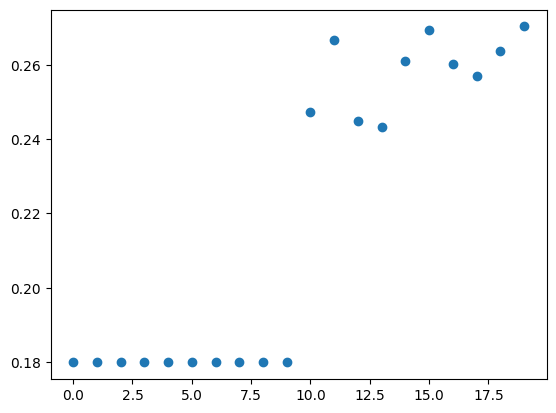

In [42]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(100)[:20],stiffness[:20])


In [18]:
from rostok.block_builder_api.block_blueprints import EnvironmentBodyBlueprint
from rostok.control_chrono.controller import SimpleKeyBoardController
from rostok.simulation_chrono.simulation_scenario import WalkingScenario
import pychrono as chrono
from rostok.utils.dataset_materials.material_dataclass_manipulating import DefaultChronoMaterialNSC
#from wheels import get_stiff_wheels, get_wheels, get_stiff_wheels_ell, get_stiff_wheels_4
from rostok.graph_grammar.graph_utils import plot_graph
from rostok.block_builder_chrono.block_builder_chrono_api import \
    ChronoBlockCreatorInterface
from rostok.block_builder_api.easy_body_shapes import Box

def create_bump_track():
    def_mat = DefaultChronoMaterialNSC()
    floor = ChronoBlockCreatorInterface.create_environment_body(EnvironmentBodyBlueprint(Box(5, 0.05, 5), material=def_mat, color=[215, 255, 0]))
    chrono_material = chrono.ChMaterialSurfaceNSC()
    #chrono_material.SetFriction(0.67)
    mesh = chrono.ChBodyEasyMesh("Bump.obj", 8000, True, True, True, chrono_material, 0.002)
    floor.body = mesh
    floor.body.SetNameString("Floor")
    floor.body.SetPos(chrono.ChVectorD(1.5,-0.07,0))
    floor.body.GetVisualShape(0).SetTexture("chess.png", 0.03, 0.03)
    floor.body.SetBodyFixed(True)
    return floor

def create_track():
    def_mat = DefaultChronoMaterialNSC()
    floor = ChronoBlockCreatorInterface.create_environment_body(EnvironmentBodyBlueprint(Box(5, 0.05, 5), material=def_mat, color=[215, 255, 0]))
    chrono_material = chrono.ChMaterialSurfaceNSC()
    #chrono_material.SetFriction(0.67)
    mesh = chrono.ChBodyEasyMesh("TRACKMANIA.obj", 8000, True, True, True, chrono_material, 0.002)
    floor.body = mesh
    floor.body.SetNameString("Floor")
    floor.body.SetPos(chrono.ChVectorD(6.6,0.02,5.2))
    floor.body.GetVisualShape(0).SetTexture("chess.png", 0.03, 0.03)
    floor.body.SetBodyFixed(True)
    return floor


graph,startings = get_rotated_six_legs_with_db(rule_vocab, 20)
floor = create_track()

scenario = WalkingScenario(0.0001, 10000, SimpleKeyBoardController)
scenario.set_floor(floor)
#graph = get_stiff_wheels_4()

parameters = {}
parameters["forward"] = 1
parameters["reverse"]= 1
parameters["forward_rotate"] = 1
parameters["reverse_rotate"] = -0.3

scenario.run_simulation(graph, parameters, starting_positions=startings, vis = True, delay=True, is_follow_camera = True)

RuntimeError: SWIG director method error. Error detected when calling 'TorqueFunctor.evaluate'